# Quantitative Spatial Economics 

## Tutorial Topic 2: Monocentric City Model

Humboldt University Berlin & Berlin School of Economics

Authors:
[Dominik Bursy](dominik.bursy@icloud.com), 
[Lars Felder](lars.felder@fu-berlin.de), 
[Kate Bablyak](kateryna.bablyak@student.hu-berlin.de), 
[Marlon Krippendorf](marlon.krippendorf@fu-berlin.de)


Last Update: May 2024

---

In Topic 2,we covered the monocentric city model in the lecture. In this tutorial, we test for the central prediction of the model, i.e. that bid-rents fall in distance from the central business district.

---

## Directory Structure

Start by cloning the repository [AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/) in the ressource directory and copy `_USE_PREDICT.do` to the notebooks directory.

```bash
├── data
│   ├── _README.txt
│   ├── county-employment-2023
│   ├── county-gdp_capita-2021
│   ├── county-wages-2022
│   ├── RWI-GEO-RED-2022
│   └── Shapefiles-2022
├── experiments
├── notebooks
│   ├── _USE_PREDICT.do
│   ├── QSE_Tutorial_1_Group_2.ipynb
│   └── QSE_Tutorial_2_Group_2.ipynb
├── output
├── resources
│   ├── AHS2023-toolkit-main
│   └── Tutorial_Handout_2.pdf
├── requirements.txt
├── README.md
└── LICENSE
```

## Table of Contents

- [Import Packages](#packages)
- [Data Import and Data Preparation](#data_import)
    - [Data Import 1: German Cities](#data_import_1)
    - [Data Import 2: Transactions Panel](#data_import_2)
    - [Data Preparation](#data_preparation)
- [Task 1: Create House Price Index](#price_index)
- [Task 2: Vizualize House Price Index](#vizualization)
- [Task 3: Price Gradient from Central Business Districts (CBD)](#price_gradient)
- [Task 4: Conclusion](#conclusion)
- [Appendix](#appendix)
- [References](#references)

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 
# from tabulate import tabulate

import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [2]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


## Data Import and Data Preparation <a class="anchor" id="data_import"></a>

In [3]:
## Create Output Directory
OUTPUT_FOLDER = f'{ROOT_FOLDER}/data/ahs_index'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
# os.rmdir(OUTPUT_FOLDER)

### Data Import 1: German Cities <a class="anchor" id="data_import_1"></a>

In [4]:
## Load shapefile of German postal codes 
gdf_zip_codes = gpd.read_file(f'{ROOT_FOLDER}/data/Shapefiles-2022/Germany/POSTCODES/postcode_clean_final.shp')

In [5]:
## Load data on German cities on postal code level 
url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-germany-postleitzahl/exports/csv?lang=en&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B'
df_cities = pd.read_csv(url, delimiter=';')

## Alternatively, load georeferenced German cities on postal code level 
# url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-germany-postleitzahl/exports/shp?lang=en&timezone=Europe%2FBerlin'
# df_cities = gpd.read_file(url)

In [6]:
## Subset to largest German cities: Berlin, Hamburg, Munich, Cologne, Frankfurt
condition_berlin = (df_cities['Kreis name'] == 'Kreisfreie Stadt Berlin')
condition_hamburg = (df_cities['Kreis name'] == 'Kreisfreie Stadt Hamburg')
condition_munich = (df_cities['PLZ Name (short)'] == 'München') ## Excludes Haar
condition_cologne = (df_cities['PLZ Name (short)'] == 'Köln') ## Excludes Gladbach
condition_frankfurt = (df_cities['Kreis name'] == 'Kreisfreie Stadt Frankfurt am Main')
# condition_frankfurt = ((df_cities['Kreis name'] == 'Kreisfreie Stadt München').astype(int) - (df_cities['PLZ Name (short)'] == 'München').astype(int)) == 1
condition_cities = [condition_berlin, condition_hamburg, condition_munich, condition_cologne, condition_frankfurt]

## Encode cities and create indicators
cities = ['berlin', 'hamburg', 'munich', 'cologne', 'frankfurt']
for index, city in enumerate(cities):
    df_cities.loc[condition_cities[index], city] = 1
    df_cities.loc[condition_cities[index], 'city'] = city
df_cities[cities] = df_cities[cities].fillna(value=0)

## Rename columns
df_cities.rename(columns={'Name':'plz'}, inplace=True)

## Drop duplicates
df_cities.drop_duplicates(subset=['plz', 'city'], inplace=True)

In [7]:
## Add city information to postal code shapefile 
gdf_zip_codes = gdf_zip_codes.set_index('ZIP').join(
    df_cities[cities + ['city', 'plz']].set_index('plz'), validate='1:m').dropna(subset=['city']).reset_index()

In [8]:
## Calculate the geographic center of each postalcode
#gdf_zip_codes['shape_center_x'] = gdf_zip_codes.centroid.x
#gdf_zip_codes['shape_center_y'] = gdf_zip_codes.centroid.y

## Rename columns and subset dataframe
gdf_zip_codes.rename(columns={'index':'target_id', 'INSIDE_X':'target_x', 'INSIDE_Y': 'target_y',
                              'OBJECTID': 'shape_id', 'Shape_Leng':'shape_length', 'Shape_Area':'shape_area', 
                              }, inplace=True)
gdf_zip_codes = gdf_zip_codes[['target_id', 'target_x', 'target_y', 'shape_id', 'shape_length', 'shape_area', #'shape_center_x', 'shape_center_y', 
                               'city', 'berlin', 'hamburg', 'munich', 'cologne', 'frankfurt', 'geometry']]

In [9]:
## Export dataframe
gdf_zip_codes.drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/centroids.dta') 
# gdf_zip_codes.loc[gdf_zip_codes['city'] == 'berlin'].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/centroids.dta') 

### Data Import 2: Transactions Panel <a class="anchor" id="data_import_2"></a>

In [10]:
## Load dataframes on housing market transcations
df_hk = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_HK_cities.dta')
df_wk = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_WK_cities.dta')
df_wm = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/panel/CampusFile_WM_cities.dta')

In [11]:
## Define transaction type: Kaufen vs Mieten
df_hk['type'] = 0
df_wk['type'] = 0
df_wm['type'] = 1

## Concatinate dataframes 
df_transactions = pd.concat([df_hk, df_wk, df_wm], axis=0)

## Drop duplicates
df_transactions.drop_duplicates(inplace=True)

## Drop missing postal codes
df_transactions = df_transactions.loc[pd.to_numeric(df_transactions['plz'], errors='coerce').notna()]
df_transactions['plz'] = df_transactions['plz'].astype(int)

In [12]:
## Merge with cities 
gdf_transactions = gdf_zip_codes.set_index('target_id').join(df_transactions.set_index('plz'), validate='1:m')

## Add x-y coordinate (in ETRS) projections
df_georeference = pd.read_stata(f'{ROOT_FOLDER}/data/RWI-GEO-RED-2022/_grid_georeferences/grid.coordinaten_xy.dta')
gdf_transactions = gdf_transactions.set_index('ergg_1km').join(df_georeference.set_index('ergg_1km'), validate='m:1').reset_index()

## Drop missing values
gdf_transactions.dropna(subset=['origin_X', 'origin_Y'], inplace=True)

### Data Preparation <a class="anchor" id="data_preparation"></a>

In [13]:
## lprice_qm and year
gdf_transactions.loc[gdf_transactions['type'] == 0, 'lprice_qm'] = np.log(gdf_transactions.loc[gdf_transactions['type'] == 0, 'price_sqm'])
gdf_transactions.loc[gdf_transactions['type'] == 1, 'lprice_qm'] = np.log(gdf_transactions.loc[gdf_transactions['type'] == 1, 'rent_sqm'])
gdf_transactions['year'] = gdf_transactions['edat'].dt.year

## Hedonic characteristics
gdf_transactions['age'] = 2022 - gdf_transactions['baujahr']
gdf_transactions.loc[gdf_transactions['etage'] == 'Other missing', 'etage'] = np.nan
gdf_transactions.loc[gdf_transactions['etage'] == 'Implausible value', 'etage'] = np.nan
gdf_transactions.loc[gdf_transactions['zimmeranzahl'] == 'Implausible value', 'zimmeranzahl'] = np.nan

## Demeaning of hedonic characteristics
for var in ['age', 'etage', 'zimmeranzahl', 'wohnflaeche']:
    #mean_val = gdf_transactions[var].mean()
    gdf_transactions[f'Att_{var}'] = gdf_transactions[var] #- mean_val
gdf_transactions['city'] = gdf_transactions['city'].astype('category')
gdf_transactions['Att_etage'] = gdf_transactions['Att_etage'].astype(float)
gdf_transactions['Att_zimmeranzahl'] = gdf_transactions['Att_zimmeranzahl'].astype(float)

In [14]:
## Rename columns and subset dataframe and drop duplicates
gdf_transactions.rename(columns={'obid':'transactions_id', 'city':'submarketid'}, inplace=True)
gdf_transactions = gdf_transactions[[
    'transactions_id', 'lprice_qm', 'year', 'Att_age', 'Att_etage', 'Att_zimmeranzahl', 'Att_wohnflaeche', 'submarketid', 'origin_X', 'origin_Y', 'type', 'geometry'
]].drop_duplicates()

In [15]:
## Export dataframe
gdf_transactions.loc[gdf_transactions['type'] == 0].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/transactions_purchase.dta') 
gdf_transactions.loc[gdf_transactions['type'] == 1].drop(columns=['geometry']).to_stata(f'{OUTPUT_FOLDER}/transactions_rent.dta') 

In [16]:
## Export dataframe
# gdf_transactions.loc[(gdf_transactions['type'] == 0) & (gdf_transactions['submarketid'] == 'berlin')].drop(columns=['geometry']).to_stata(f'{ROOT_FOLDER}/transactions_purchase.dta') 
# gdf_transactions.loc[(gdf_transactions['type'] == 1) & (gdf_transactions['submarketid'] == 'berlin')].drop(columns=['geometry']).to_stata(f'{ROOT_FOLDER}/transactions_rent.dta') 

---

## Task 1: Create House Price Index <a class="anchor" id="price_index"></a>

In [231]:
# Setup Stata
import stata_setup
stata_setup.config("/Applications/Stata", "se", splash=True)


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      StataNow 18.5
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-782-8272        https://www.stata.com
                                   979-696-4600        service@stata.com

Stata license: Unlimited-user network, expiring 13 Oct 2025
Serial number: 401809306098
  Licensed to: Dominik Bursy
               Freie Universität Berlin

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [232]:
%%stata
cd ..
pwd


. cd ..
/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration

. pwd
/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration

. 


In [36]:
%%stata
use "data/ahs_index/centroids.dta", clear
global transaction_dataset "data/ahs_index/transactions_purchase.dta"
do "notebooks/_USE_PREDICT.do"
save "data/ahs_index/AHS_Index_purchase.dta", replace


. pwd
/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration

. use "data/ahs_index/centroids.dta", clear

. global transaction_dataset "data/ahs_index/transactions_purchase.dta"

. do "notebooks/_USE_PREDICT.do"

. // This do file generates an rental price index for 1km Hexagons for the Berl
> in rental market.
. // By Gabriel M Ahlfeldt 2021
. // For Stata 16
. 
. 
. 
. * Set temporary woring directory
. global WD "data/ahs_index/ahs_temporary" // Name of temporary directory

. 
. 
. * Create temporary working direktory
. capture shell rmdir "$WD" /s /q

. mkdir $WD

. 
. // FULL RUN
. 
. * 0) LOAD PROGRAM
.         capture drop program PREDICT // Drop program if already loaded

.         do "resources/AHS2023-toolkit-main/DOS/_AUX_PROG"

. *****************************************************************************
> ***
. * (C) Gabriel M. Ahlfeldt, LSE, CEPR 2020
. * For Stata 16.0
. *****************************************************************************
> ***

rmdir: /s: No such file or directory
rmdir: /q: No such file or directory


Iteration 1 of 447 completed, kernel radius = 5 km, using 34689 observations
Iteration 2 of 447 completed, kernel radius = 5 km, using 37806 observations
Iteration 3 of 447 completed, kernel radius = 5 km, using 38140 observations
Iteration 4 of 447 completed, kernel radius = 5 km, using 39122 observations
Iteration 5 of 447 completed, kernel radius = 5 km, using 38181 observations
Iteration 6 of 447 completed, kernel radius = 5 km, using 33614 observations
Iteration 7 of 447 completed, kernel radius = 5 km, using 23785 observations
Iteration 8 of 447 completed, kernel radius = 5 km, using 28605 observations
Iteration 9 of 447 completed, kernel radius = 5 km, using 34185 observations
Iteration 10 of 447 completed, kernel radius = 5 km, using 11466 observations
Iteration 11 of 447 completed, kernel radius = 5 km, using 16887 observations
Iteration 12 of 447 completed, kernel radius = 10 km, using 34888 observations
Iteration 13 of 447 completed, kernel radius = 5 km, using 11700 observa

rmdir: data/ahs_index/ahs_temporary: Directory not empty
rmdir: /s: No such file or directory
rmdir: /q: No such file or directory


In [42]:
%%stata
use "data/ahs_index/centroids.dta", clear
global transaction_dataset "data/ahs_index/transactions_rent.dta"
do "notebooks/_USE_PREDICT.do" 
save "data/ahs_index/AHS_Index_rent.dta", replace


. use "data/ahs_index/centroids.dta", clear

. global transaction_dataset "data/ahs_index/transactions_rent.dta"

. do "notebooks/_USE_PREDICT.do" 

. // This do file generates an rental price index for 1km Hexagons for the Berl
> in rental market.
. // By Gabriel M Ahlfeldt 2021
. // For Stata 16
. 
. 
. 
. * Set temporary woring directory
. global WD "data/ahs_index/ahs_temporary" // Name of temporary directory

. 
. 
. * Create temporary working direktory
. capture shell rmdir "$WD" /s /q



. mkdir $WD

. 
. // FULL RUN
. 
. * 0) LOAD PROGRAM
.         capture drop program PREDICT // Drop program if already loaded

.         do "resources/AHS2023-toolkit-main/DOS/_AUX_PROG"

. *****************************************************************************
> ***
. * (C) Gabriel M. Ahlfeldt, LSE, CEPR 2020
. * For Stata 16.0
. *****************************************************************************
> ***
. 
. // This program loads estimates a property price index for arbitrary coordina
> tes
. // in the target data set using property information in the origin data set
. // Origin and target coordinates must be in projected meter units
. 
. // PREDICT SYNTAX: PREDICT A B C D E F G H I J K L M N
.         * A n_id that starts the loop, usually 1
.         * B n_id that ends the loop, usually $N (global for max. n_id)
.         * C first year if index
.         * D last year of index
.         * E Spatial window: Search for observations within this distance thre
> shold in

rmdir: data/ahs_index/ahs_temporary: No such file or directory
rmdir: /s: No such file or directory
rmdir: /q: No such file or directory



. 
. // PREDICT SYNTAX: PREDICT A B C D E F G H I J K L M N
.         * A n_id that starts the loop, usually 1
.         * B n_id that ends the loop, usually $N (global for max. n_id)
.         * C first year if index
.         * D last year of index
.         * E Search for observations within this distance threshold in km firs
> t, e.g. 10 
.         * F If not enough obs within E km, switch to F, e.g. 25
.         * G If not enough obs within F km, switch to G, e.g. 50
.         * H If stil not enough obs, switch to H, 100
.         * I Defines the number of obs in the above decision rule. e.g. 20000
.         * J searches for observations within this distance in km for spatial 
> fixed effect, e.g. 2.5
.         * K If not enough obs within E km, switch to F, e.g. 5
.         * L If not enough obs within E km, switch to F, e.g. 10
.         * M If not enough obs within E km, switch to F, e.g. 20
.         * N Defines the number of obs in the above spatial fixed effect decis
> ion 

In [43]:
## Remove temporary files
os.remove(f'{OUTPUT_FOLDER}/AHS-Index.csv')
os.remove(f'{OUTPUT_FOLDER}/AHS-Index.dta')

---

## Task 2: Vizualize House Price Index<a class="anchor" id="vizualization"></a>

In [136]:
gdf_purchase_index = gdf_zip_codes.set_index('shape_id').join(pd.read_stata(f'{OUTPUT_FOLDER}/AHS_Index_purchase.dta').set_index('shape_id'))
gdf_rent_index = gdf_zip_codes.set_index('shape_id').join(pd.read_stata(f'{OUTPUT_FOLDER}/AHS_Index_rent.dta').set_index('shape_id'))

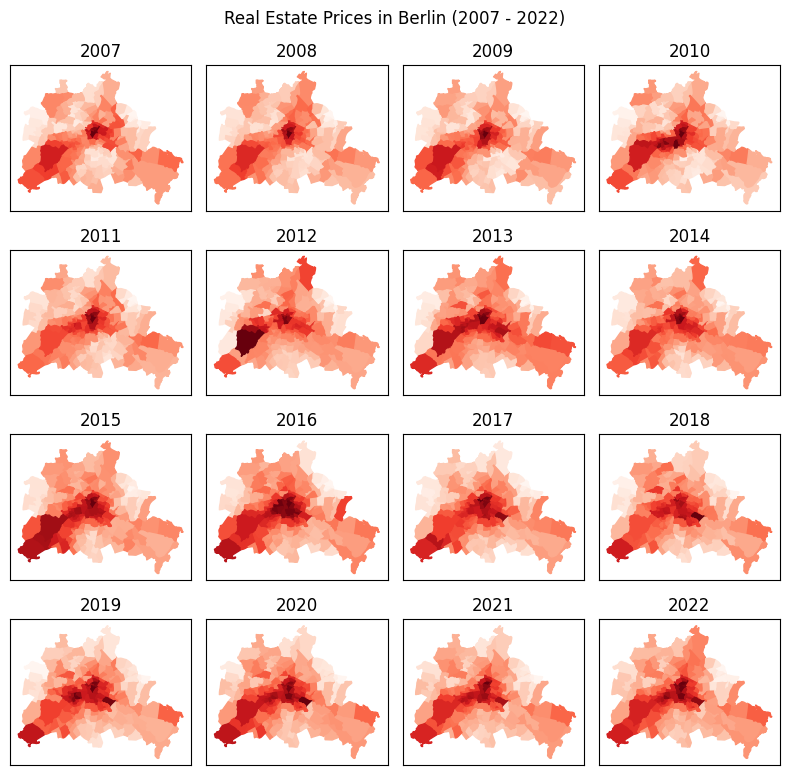

In [144]:
figure, axis = plt.subplots(4, 4, figsize=(8, 8)) 
axis = axis.flatten()

for index, year in enumerate(range(2007, 2023)):
    gdf_purchase_index.loc[gdf_rent_index['city'] == 'berlin'].plot(column='price_qm'+str(year), cmap='Reds', edgecolor='face', ax=axis[index])
    axis[index].set_xticks([])
    axis[index].set_yticks([])
    axis[index].set_title(f'{year}')
figure.suptitle('Real Estate Prices in Berlin (2007 - 2022)')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/_purchase_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

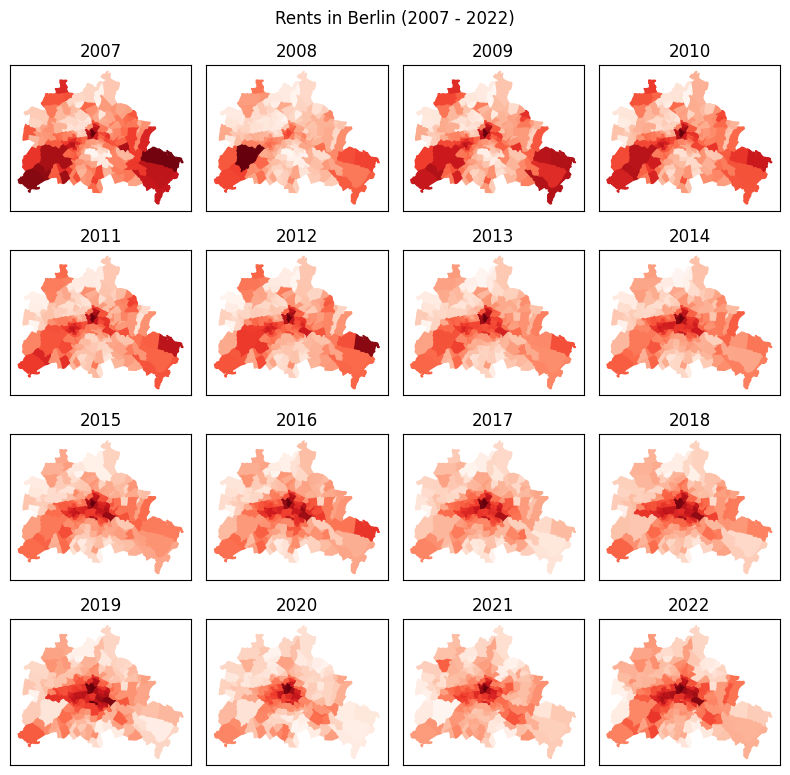

In [145]:
figure, axis = plt.subplots(4, 4, figsize=(8, 8)) 
axis = axis.flatten()

for index, year in enumerate(range(2007, 2023)):
    gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].plot(column='price_qm'+str(year), cmap='Reds', edgecolor='face', ax=axis[index])
    axis[index].set_xticks([])
    axis[index].set_yticks([])
    axis[index].set_title(f'{year}')
figure.suptitle('Rents in Berlin (2007 - 2022)')

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/rents_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

In [140]:
gdf_purchase_index['dlprice_qm'] = np.log(gdf_purchase_index['price_qm2022']) - np.log(gdf_purchase_index['price_qm2007'])
gdf_rent_index['dlprice_qm'] = np.log(gdf_rent_index['price_qm2022']) - np.log(gdf_rent_index['price_qm2007'])

In [141]:
## Shapefile Stadtbezirke Berlin
# https://daten.odis-berlin.de/de/dataset/bezirksgrenzen/
gdf_berlin = gpd.read_file('https://tsb-opendata.s3.eu-central-1.amazonaws.com/bezirksgrenzen/bezirksgrenzen.geojson')
gdf_berlin.to_crs('25832', inplace=True)

## Shapefile Stadtbezirke Munich
# https://opendata.muenchen.de/dataset?res_format=WMS
# gdf_munich = gpd.read_file('https://geoportal.muenchen.de/geoserver/gsm_wfs/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=gsm_wfs:vablock_stadtbezirke_opendata&outputFormat=application/json')

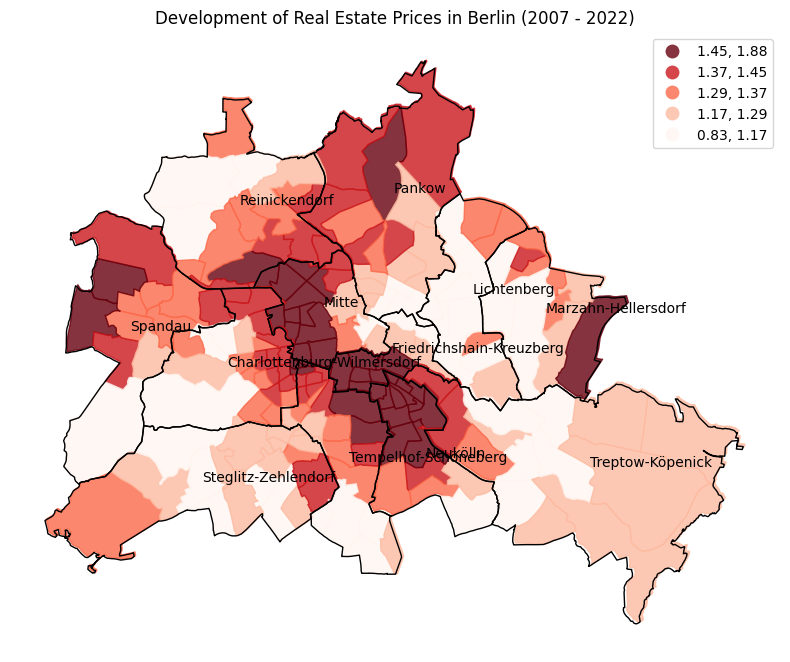

In [287]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Real Estate Prices in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_purchase_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

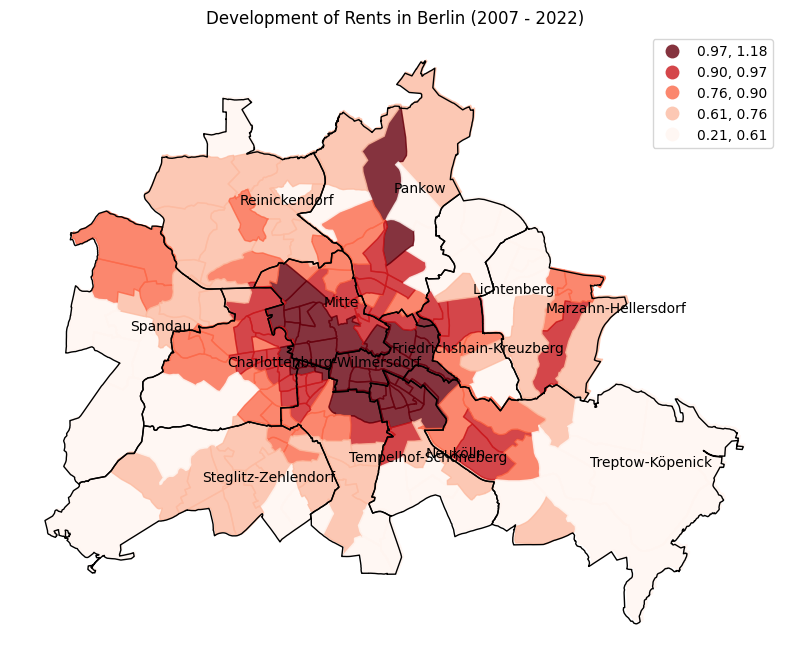

In [143]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Rents in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_rents_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

After plotting, here’s what we find:

- Real estate stable patterns over time 
- Start of the Covid pandemic 27 January 2020
- Berlin has many centers
- Center increases over time

---

## Task 3: Price Gradient from Central Business Districts (CBD) <a class="anchor" id="price_gradient"></a>

[https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file](#https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file)

In [ ]:
## The CBD is the place in the city that congregates the largest share of employment. 
condition_cbd = (gdf_purchase_index['city'] == 'berlin') & (gdf_purchase_index['target_id'] == 10117)
gdf_purchase_index.loc[condition_cbd, 'cbd'] = 1
condition_cbd = (gdf_purchase_index['city'] == 'hamburg') & (gdf_purchase_index['target_id'] == 20148)
gdf_purchase_index.loc[condition_cbd, 'cbd'] = 1
condition_cbd = (gdf_purchase_index['city'] == 'munich') & (gdf_purchase_index['target_id'] == 80331)
gdf_purchase_index.loc[condition_cbd, 'cbd'] = 1
condition_cbd = (gdf_purchase_index['city'] == 'cologne') & (gdf_purchase_index['target_id'] == 50667)
gdf_purchase_index.loc[condition_cbd, 'cbd'] = 1
condition_cbd = (gdf_purchase_index['city'] == 'frankfurt') & (gdf_purchase_index['target_id'] == 60313)
gdf_purchase_index.loc[condition_cbd, 'cbd'] = 1

gdf_purchase_index['cbd'] = gdf_purchase_index['cbd'].fillna(value=0)

In [250]:
## Transform prices to log prices 
for year in range(2007, 2023):
    gdf_purchase_index['lprice_qm'+str(year)] = np.log(gdf_purchase_index['price_qm'+str(year)])

In [ ]:
condition_cbd = (gdf_purchase_index['city'] == 'berlin') & (gdf_purchase_index['target_id'] == 10117)
condition_cbd_not = (gdf_purchase_index['city'] == 'berlin') 

## Distance using R2 Norm
gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] = np.sqrt(
    (gdf_purchase_index.loc[condition_cbd_not, 'target_x'] - gdf_purchase_index.loc[condition_cbd, 'target_x'].values)**2 + 
    (gdf_purchase_index.loc[condition_cbd_not, 'target_y'] - gdf_purchase_index.loc[condition_cbd, 'target_y'].values)**2
)

## Disnace using Geopandas
# from shapely.geometry import Point
# gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].distance(
#     Point(gdf_purchase_index.loc[condition_cbd, 'target_x'], gdf_purchase_index.loc[condition_cbd, 'target_y']), align=True)

In [322]:
## Log-Level Model
import statsmodels.api as sm

Y = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'lprice_qm2007']
X = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          lprice_qm2007   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     24.95
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.34e-06
Time:                        22:53:05   Log-Likelihood:                -8.8875
No. Observations:                 190   AIC:                             21.77
Df Residuals:                     188   BIC:                             28.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4134      0.040    186.549      0.0

In [323]:
## Log-Level Model
import statsmodels.api as sm

Y = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'dlprice_qm']
X = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             dlprice_qm   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     31.41
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           7.36e-08
Time:                        22:53:06   Log-Likelihood:                 66.548
No. Observations:                 190   AIC:                            -129.1
Df Residuals:                     188   BIC:                            -122.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4651      0.027     54.837      0.0

In [324]:
condition = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 2500
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 5
condition = (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 2500) & (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 5000)
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 4
condition = (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 5000) & (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 7500)
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 3
condition = (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 7500) & (gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] < 10000)
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 2
condition = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance'] >= 10000
gdf_purchase_index.loc[(gdf_purchase_index['city'] == 'berlin') & condition, 'distance_dummy'] = 1


In [325]:
## Log-Level Model

import statsmodels.api as sm

Y = gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'dlprice_qm']
X = pd.get_dummies(gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin', 'distance_dummy'], drop_first=True)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             dlprice_qm   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     11.35
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.92e-08
Time:                        22:53:16   Log-Likelihood:                 72.726
No. Observations:                 190   AIC:                            -135.5
Df Residuals:                     185   BIC:                            -119.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2490      0.020     62.486      0.0

In [326]:
## Berlin CBD: 10117
## Munich CBD: 80331
# gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].sjoin(gpd.read_file('/Users/dominik.bursy/Downloads/shape_11/PL_11.shp').to_crs(gdf_rent_index.loc[gdf_rent_index['city'] == 'berlin'].crs))

---

In [327]:
from shapely.geometry import Point

condition_cbd = (gdf_purchase_index['city'] == 'berlin') & (gdf_purchase_index['target_id'] == 10117)
df = pd.DataFrame({"Coordinates": [Point(gdf_purchase_index.loc[condition_cbd, 'target_x'], gdf_purchase_index.loc[condition_cbd, 'target_y'])]})

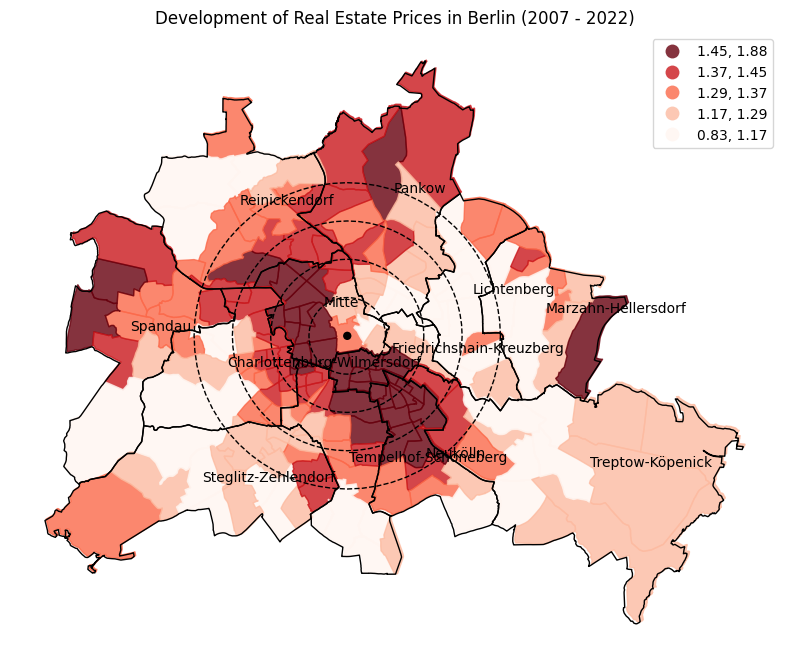

In [328]:
figure, axis = plt.subplots(1, 1, figsize=(8, 8)) 

gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='dlprice_qm', cmap='Reds', edgecolor='face', ax=axis, alpha=0.8,
                                                                    # legend=True, legend_kwds={'orientation':'horizontal', "pad": 0})
                                                                    legend=True, scheme="quantiles", legend_kwds=dict(loc='upper right', reverse=True, ncol=1))

gdf_berlin.plot(facecolor='none', edgecolor='black', linewidth=1, ax=axis)

gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).plot(facecolor='black', edgecolor='none', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(2500).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(5000).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(7500).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)
gpd.GeoDataFrame(df, geometry=df['Coordinates'], crs=gdf_purchase_index.crs).buffer(10000).plot(facecolor='none', edgecolor='black', linestyle='--', linewidth=1, ax=axis)

for x, y, label in zip(gdf_berlin.centroid.x, gdf_berlin.centroid.y, gdf_berlin.Gemeinde_name):
    axis.annotate(label, xy=(x, y), xytext=(1, 3), textcoords='offset points', fontsize=10)

axis.set_axis_off()

axis.set_title('Development of Real Estate Prices in Berlin (2007 - 2022)')

handles, labels = axis.get_legend_handles_labels()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/development_purchase_berlin.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

## Task 4: Conclusion <a class="anchor" id="conclusion"></a>

Add conclusion here

---

## Appendix <a class="anchor" id="appendix"></a>

In [331]:
## Normalize price index over the years

def normalize_min_max(df_column):
    return (df_column - df_column.min().min()) / (df_column.max().max() - df_column.min().min())

gdf_purchase_index.iloc[:,gdf_purchase_index.columns.str.startswith('price_qm')] = normalize_min_max(gdf_purchase_index.iloc[:,gdf_purchase_index.columns.str.startswith('price_qm')])

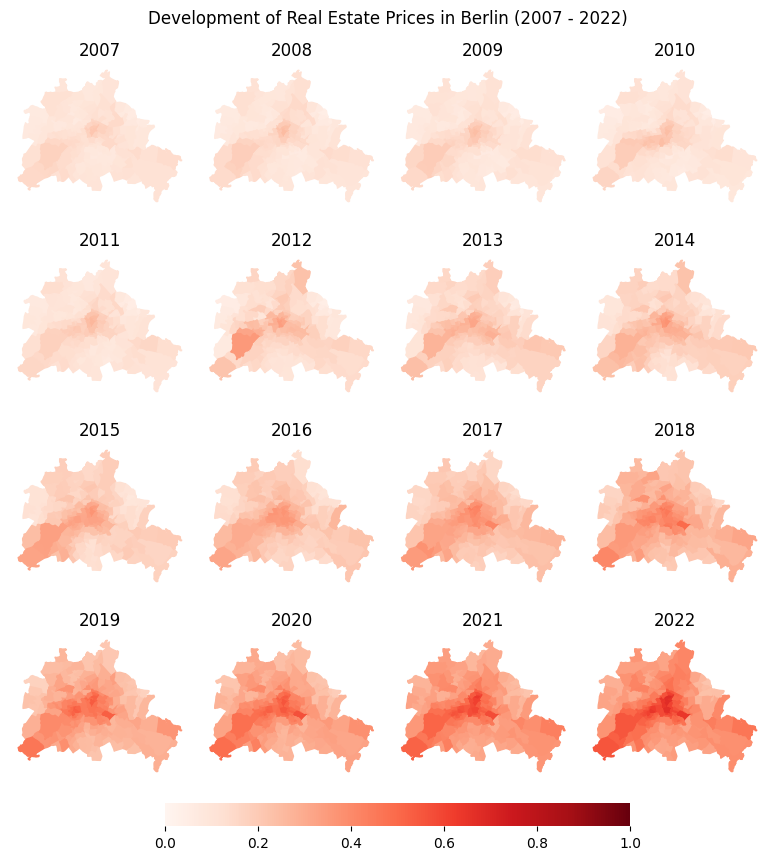

In [332]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

figure, axis = plt.subplots(4, 4, figsize=(8, 8)) 
axis = axis.flatten()

normalizer = Normalize(0, 1)
im = cm.ScalarMappable(norm=normalizer, cmap='Reds')

for index, year in enumerate(range(2007, 2023)):
    gdf_purchase_index.loc[gdf_purchase_index['city'] == 'berlin'].plot(column='price_qm'+str(year), cmap='Reds', edgecolor='face', ax=axis[index], norm=normalizer)
    # axis[index].set_xticks([])
    # axis[index].set_yticks([])
    axis[index].set_axis_off()
    axis[index].set_title(f'{year}')
figure.suptitle('Development of Real Estate Prices in Berlin (2007 - 2022)')

cb = figure.colorbar(im, ax=axis.ravel().tolist(), location='bottom', orientation='horizontal', shrink=0.75, anchor=(0.5, -1.75))
cb.outline.set_visible(False)

figure.tight_layout()

## References <a class="anchor" id="references"></a>

- [GitHub AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)
- ...
- ...

---